In [1]:
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from scipy.stats import gaussian_kde

sys.path.append(os.path.expanduser('~/Documents/Hybrid/'))
from Hybrid.verification import load_tganom_and_compute, load_tgex_and_compute, build_fit_nn_model, compute_bss, compute_kss, compute_auc, reduce_to_ranks, reduce_to_skill

sys.path.append(os.path.expanduser('~/Documents/Weave/'))
from Weave.utils import reliability_plot

2022-01-21 13:01:07.383106: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-21 13:01:07.383127: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Investigation of most successful prediction
(When going through the standard objective predictor selection).

In [2]:
name = 'tg-anom_JJA_45r1_31D-roll-mean_q0.5_sep12-15'
total, test_only = build_fit_nn_model(predictandname = name, npreds = 4, use_jmeasure=False)
trainval_only = total.drop(test_only.index, axis = 0)

fitting a new feature scaler
using a pre-fitted feature scaler
Epoch 1/200


2022-01-11 17:05:40.927006: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-01-11 17:05:40.927040: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-01-11 17:05:40.927065: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc160104): /proc/driver/nvidia/version does not exist
2022-01-11 17:05:40.927264: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-11 17:05:40.978571: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optim

41/41 [==============================] - 0s 4ms/step - loss: 0.7260 - accuracy: 0.5498 - brier: 0.2597 - val_loss: 0.7860 - val_accuracy: 0.4826 - val_brier: 0.2891
Epoch 2/200
41/41 [==============================] - 0s 997us/step - loss: 0.7235 - accuracy: 0.5498 - brier: 0.2584 - val_loss: 0.7838 - val_accuracy: 0.4826 - val_brier: 0.2883
Epoch 3/200
41/41 [==============================] - 0s 999us/step - loss: 0.7196 - accuracy: 0.5653 - brier: 0.2565 - val_loss: 0.7804 - val_accuracy: 0.4826 - val_brier: 0.2870
Epoch 4/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7123 - accuracy: 0.5793 - brier: 0.2532 - val_loss: 0.7752 - val_accuracy: 0.4905 - val_brier: 0.2848
Epoch 5/200
41/41 [==============================] - 0s 1ms/step - loss: 0.7018 - accuracy: 0.5793 - brier: 0.2485 - val_loss: 0.7684 - val_accuracy: 0.4968 - val_brier: 0.2819
Epoch 6/200
41/41 [==============================] - 0s 1ms/step - loss: 0.6879 - accuracy: 0.5972 - brier: 0.2419 - val_lo

41/41 [==============================] - 0s 1ms/step - loss: 0.5331 - accuracy: 0.7589 - brier: 0.1705 - val_loss: 0.6244 - val_accuracy: 0.6356 - val_brier: 0.2191
Epoch 48/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5319 - accuracy: 0.7621 - brier: 0.1697 - val_loss: 0.6212 - val_accuracy: 0.6341 - val_brier: 0.2181
Epoch 49/200
41/41 [==============================] - 0s 996us/step - loss: 0.5316 - accuracy: 0.7628 - brier: 0.1697 - val_loss: 0.6214 - val_accuracy: 0.6341 - val_brier: 0.2181
Epoch 50/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5320 - accuracy: 0.7566 - brier: 0.1699 - val_loss: 0.6216 - val_accuracy: 0.6341 - val_brier: 0.2182
Epoch 51/200
41/41 [==============================] - 0s 991us/step - loss: 0.5319 - accuracy: 0.7589 - brier: 0.1697 - val_loss: 0.6237 - val_accuracy: 0.6341 - val_brier: 0.2186
Epoch 52/200
41/41 [==============================] - 0s 1ms/step - loss: 0.5317 - accuracy: 0.7613 - brier: 0.1696 - v

In [3]:
n_iter = 2000
bs = pd.DataFrame(np.nan, columns = pd.MultiIndex.from_product([['trainval','test'],test_only.columns[test_only.columns.str.endswith('_bs')]], names = ['set','forecast']), index = pd.RangeIndex(n_iter))
for i in range(n_iter):

    trainval_sample = np.random.randint(low = 0, high = trainval_only.shape[0], size = trainval_only.shape[0]) # bootstrap sample with replacement.
    test_sample = np.random.randint(low = 0, high = test_only.shape[0], size = test_only.shape[0])
    
    for forecast_key in bs.columns.get_level_values('forecast').unique():
        bs.loc[i,('test',forecast_key)] = test_only[forecast_key].iloc[test_sample.tolist()].mean()
        bs.loc[i,('trainval',forecast_key)] = trainval_only[forecast_key].iloc[trainval_sample.tolist()].mean()

In [4]:
bs.columns

MultiIndex([('trainval',          'pi_bs'),
            ('trainval',        'ppsf_bs'),
            ('trainval', 'climatology_bs'),
            ('trainval',       'trend_bs'),
            (    'test',          'pi_bs'),
            (    'test',        'ppsf_bs'),
            (    'test', 'climatology_bs'),
            (    'test',       'trend_bs')],
           names=['set', 'forecast'])

In [5]:
# scale test and trainval BS separately based on the mean raw score
bszero = bs.copy()
bszero['test'] = bs['test'] - float(bs[('test', 'pi_bs')].mean())
bszero['trainval'] = bs['trainval'] - float(bs[('trainval', 'pi_bs')].mean())

In [6]:
def to_kernel_density(vals):
    if isinstance(vals, (pd.Series, pd.DataFrame)):
        vals = vals.values.squeeze()
    positions = np.linspace(start = vals.min(), stop = vals.max(), num = 100)
    density = gaussian_kde(vals)(positions)
    return(positions, density)

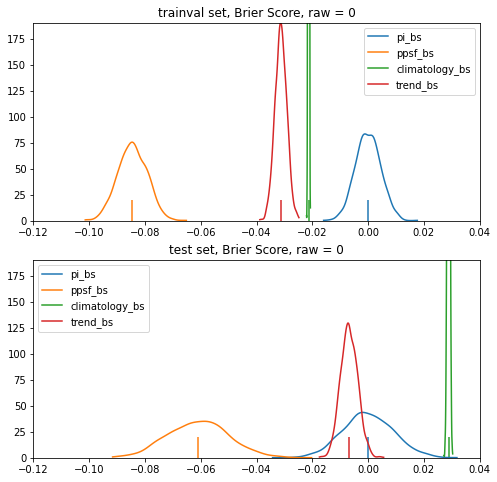

In [7]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (8,8), squeeze = False)
for key in bszero.columns:
    i = bszero.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    im = ax.plot(*to_kernel_density(bszero[key]),label = key[-1])
    ax.vlines(x = float(bszero[key].mean()), ymin=0, ymax = 20, color = im[0].get_c())
    ax.set_xlim(left = -0.12, right = 0.04)
    ax.set_ylim(0,190)
    ax.set_title(f'{key[0]} set, Brier Score, raw = 0')
    ax.legend()

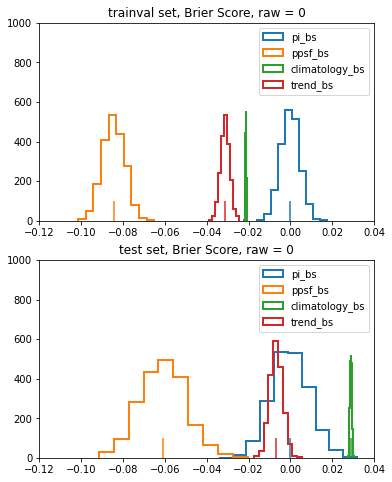

In [15]:
fig, axes = plt.subplots(ncols=1, nrows = 2, figsize = (6,8), squeeze = False)
for key in bszero.columns:
    i = bszero.columns.get_level_values(0).unique().tolist().index(key[0])
    ax = axes[i,0]
    im = ax.hist(bszero[key], label = key[-1], histtype = 'step', lw = 2)
    ax.vlines(x = float(bszero[key].mean()), ymin=0, ymax = 100, color = im[2][0].get_edgecolor())
    #ax.set_xlim(left = -0.12, right = 0.08)
    ax.set_xlim(left = -0.12, right = 0.04)
    ax.set_ylim(0,1000)
    ax.set_title(f'{key[0]} set, Brier Score, raw = 0')
    ax.legend()

In [9]:
test_only.columns.name = 'type'
trainval_only.columns.name = 'type'

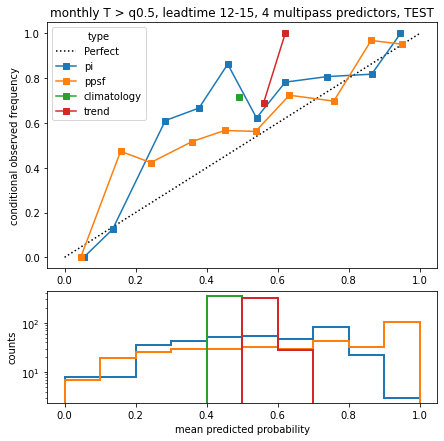

In [14]:
fig, (axrel, axhist) = reliability_plot(y_true = test_only['observation'], y_probs=test_only[['pi', 'ppsf', 'climatology','trend']])
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TEST')
plt.show()

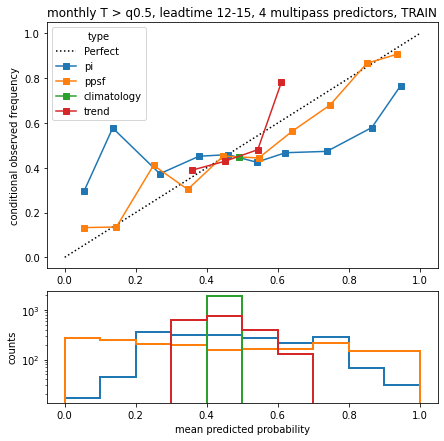

In [13]:
fig, (axrel, axhist) = reliability_plot(y_true = trainval_only['observation'], y_probs=trainval_only[['pi', 'ppsf', 'climatology','trend']])
axrel.set_title('monthly T > q0.5, leadtime 12-15, 4 multipass predictors, TRAIN')
plt.show()

## Broad verification
Multiple metrics, thresholds, time scales, lead times. Currently post-processed combinations are not post-processed with jmeasure input.

In [2]:
def extra_scores_and_skill(df):
    compute_kss(df)
    compute_auc(df)
    return reduce_to_skill(df)

In [17]:
# Handle all the tganom post-processed combinations with objective sequential forward predictors.
# And with the jmeasure data
# We will look at test data and trainval data separately
timeaggs = [21,31]
quantiles = [0.5, 0.66, 0.75, 0.9]
# npreds based on minimum of 6% improvement
md_npreds = pd.Series([3,2,3,3,4,2,2,3], index = pd.MultiIndex.from_product([timeaggs, quantiles], names = ['timeagg','quantile'])) # This is a mixture of >3% >4%
#npreds = pd.Series(4,index = pd.MultiIndex.from_product([timeaggs, quantiles], names = ['timeagg','quantile']))
cd_npreds = pd.Series([3,2,4,4,3,3,3,3], index = pd.MultiIndex.from_product([timeaggs, quantiles], names = ['timeagg','quantile'])) # This is a mixture of >3% >4%

def get_tganom_predictions(timeagg: int, quantile: float):
    name = f'tg-anom_JJA_45r1_{timeagg}D-roll-mean_q{quantile}_sep12-15'
    total_mdsf, test_mdsf = build_fit_nn_model(predictandname = name, npreds = md_npreds.loc[(timeagg,quantile)], use_jmeasure=False)
    total_mdjm, test_mdjm = build_fit_nn_model(predictandname = name, npreds = 6, use_jmeasure=True)
    total_cdsf, test_cdsf = build_fit_nn_model(predictandname = name, npreds = cd_npreds.loc[(timeagg,quantile)], use_jmeasure=False, do_climdev=True)
    total = total_mdsf.join(total_mdjm[['ppmdjm','ppmdjm_bs']]).join(total_cdsf[['ppcdsf','ppcdsf_bs']])
    trainval = total.drop(test_mdsf.index, axis = 0)
    test = total.loc[test_mdsf.index,:]
    return trainval, test
results_test = []
results_trainval = []
for timeagg, quantile in md_npreds.index:
    trainval, test = get_tganom_predictions(timeagg, quantile)
    results_trainval.append(extra_scores_and_skill(trainval))
    results_test.append(extra_scores_and_skill(test))
ranktganom_test = pd.concat(results_test, axis = 1, keys = md_npreds.index).T
ranktganom_trainval = pd.concat(results_trainval, axis = 1, keys = md_npreds.index).T

fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00038: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn

fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00044: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn

fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn

fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00063: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn

fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00033: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn

fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00058: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00031: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn

fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00018: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00050: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn

fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00019: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00008: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn

In [18]:
# Handle the tg-ex postprocessed. Test_only.
ndaythresh = [5,7,9,11]
md_npreds = pd.Series([2,3,4,4], index = pd.Index(ndaythresh, name = 'nday_threshold'))
#npreds = pd.Series(4, index = pd.Index(ndaythresh, name = 'nday_threshold'))
cd_npreds = pd.Series([5,2,5,3], index = pd.Index(ndaythresh, name = 'nday_threshold'))

results_test = []
results_trainval = []
for th in ndaythresh:
    name = f'tg-ex-q0.75-21D_ge{th}D_sep12-15'
    total_mdsf, test_mdsf = build_fit_nn_model(predictandname = name, npreds = md_npreds.loc[th], use_jmeasure=False)
    total_mdjm, test_mdjm = build_fit_nn_model(predictandname = name, npreds = 6, use_jmeasure=True)
    total_cdsf, test_cdsf = build_fit_nn_model(predictandname = name, npreds = cd_npreds.loc[th], use_jmeasure=False, do_climdev=True)
    total = total_mdsf.join(total_mdjm[['ppmdjm','ppmdjm_bs']]).join(total_cdsf[['ppcdsf','ppcdsf_bs']])
    trainval = total.drop(test_mdsf.index, axis = 0)
    test = total.loc[test_mdsf.index,:]
    results_trainval.append(extra_scores_and_skill(trainval))
    results_test.append(extra_scores_and_skill(test))
ranktgex_test = pd.concat(results_test, axis = 1, keys = md_npreds.index).T
ranktgex_trainval = pd.concat(results_trainval, axis = 1, keys = md_npreds.index).T

fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00036: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00012: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn

fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00016: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00015: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn

fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00035: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00028: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn

fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00024: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
fitting a new feature scaler
fitting a new time scaler
using a pre-fitted feature scaler
Restoring model weights from the end of the best epoch.
Epoch 00022: early stopping
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn

In [16]:
# Handle the tg-anom un-postprocessed. Also only test_only (not included in logistic fit). Currently only 21day
def get_raw_tganom(timeagg: int, quantile: float):
    climname = f'tg-anom_clim_1998-06-07_2019-10-31_{timeagg}D-roll-mean_15-t2m-q095-adapted-mean_15_15_q{quantile}' 
    modelclimname = f'tg-anom_45r1_1998-06-07_2019-08-31_{timeagg}D-roll-mean_15-t2m-q095-adapted-mean_15_15_q{quantile}'
    booksname = f'books_paper3-1_tg-anom_JJA_45r1_{timeagg}D-roll-mean_15-t2m-q095-adapted-mean.csv'
    df = load_tganom_and_compute(bookfile = booksname, climname = climname, modelclim = modelclimname, add_trend = True, return_trend = False)
    return df
#results = []
#for quantile in quantiles:
#    temp = get_raw_tganom(21, quantile)
#    temp = temp.loc[temp.index.get_level_values('time').year.isin(test_sf.index.get_level_values('time').year.unique()),:].sort_index() # Only the test data. 
#    temp = temp.loc[(slice(None),slice(0,3),9),:] #But with the desired leadtimes. And one cluster only.
#    results.append(extra_scores_and_skill(temp))
#rankraw = pd.concat(results, axis = 1, keys = pd.Index(quantiles, name = 'quantile')).T

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, 

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler


/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, 

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler


/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/nobackup_1/users/straaten/DLVENV/lib64/python3.9/site-packages/pandas/core/generic.py:4147: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, 

climatology directly loaded
climatology directly loaded
lazy pi and bool observation construction
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 20

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a 

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excluding test years [2013 2015 2016 2019] from logistic trend fit
fitting a new time scaler
using a pre-fitted time scaler
excludin

/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:110: UserWarning: kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('kuipers skill score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')
/usr/people/straaten/Documents/Hybrid/Hybrid/verification.py:115: UserWarning: AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling
  warnings.warn('AUC score aggregates the whole frame to a single float, so can only be called on a homogeneous set. Check the leadtimes you are pooling')


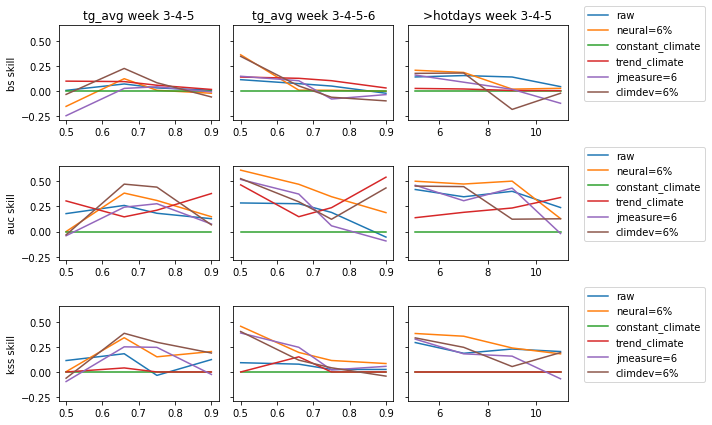

In [19]:
fig, axes = plt.subplots(nrows=3, ncols = 3, figsize = (10,6), sharey = True, facecolor='white')
aliases = pd.Series(['raw','neural=6%','constant_climate','trend_climate','jmeasure=6','climdev=6%'], index = ['pi','ppmdsf','climatology','trend','ppmdjm','ppcdsf'])
def plotranks(ax, plotframe):
    plotframe = plotframe.copy()
    plotframe.columns = plotframe.columns.droplevel(0)
    #if not ('ppsf' in plotframe.columns):
    #    plotframe['ppsf'] = np.nan
    for label in aliases.index:
        ax.plot(plotframe.index, plotframe[label], label = aliases.loc[label])
    return ax
for i,score in enumerate(ranktganom_test.columns.get_level_values('score').unique()):

    plotranks(ax = axes[i,0], plotframe = ranktganom_test.loc[21,(score,slice(None))]) # Then pp tganom 21
    plotranks(ax = axes[i,1], plotframe = ranktganom_test.loc[31,(score,slice(None))]) # Then pp tganom 31
    plotranks(ax = axes[i,2], plotframe = ranktgex_test.loc[:,(score,slice(None))]) # Then hotdays

    axes[i,2].legend(loc = (1.1,0.2))
    axes[i,0].set_ylabel(f'{score} skill')

axes[0,0].set_title('tg_avg week 3-4-5')
axes[0,1].set_title('tg_avg week 3-4-5-6')
axes[0,2].set_title('>hotdays week 3-4-5')
plt.tight_layout()

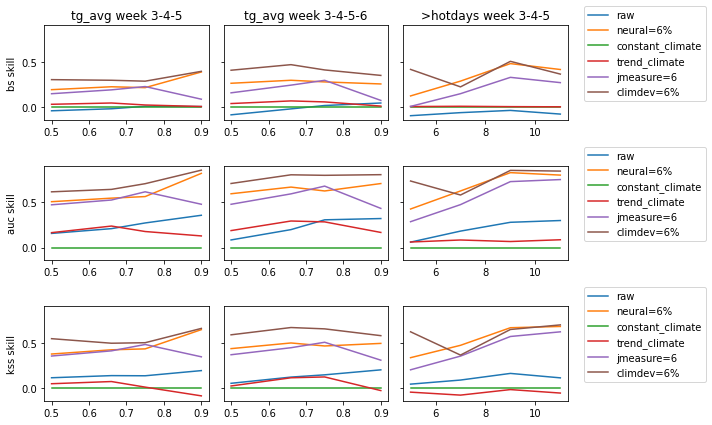

In [20]:
fig, axes = plt.subplots(nrows=3, ncols = 3, figsize = (10,6), sharey = True, facecolor='white')
aliases = pd.Series(['raw','neural=6%','constant_climate','trend_climate','jmeasure=6','climdev=6%'], index = ['pi','ppmdsf','climatology','trend','ppmdjm','ppcdsf'])
def plotranks(ax, plotframe):
    plotframe = plotframe.copy()
    plotframe.columns = plotframe.columns.droplevel(0)
    #if not ('ppsf' in plotframe.columns):
    #    plotframe['ppsf'] = np.nan
    for label in aliases.index:
        ax.plot(plotframe.index, plotframe[label], label = aliases.loc[label])
    return ax
for i,score in enumerate(ranktganom_test.columns.get_level_values('score').unique()):

    plotranks(ax = axes[i,0], plotframe = ranktganom_trainval.loc[21,(score,slice(None))]) # Then pp tganom 21
    plotranks(ax = axes[i,1], plotframe = ranktganom_trainval.loc[31,(score,slice(None))]) # Then pp tganom 31
    plotranks(ax = axes[i,2], plotframe = ranktgex_trainval.loc[:,(score,slice(None))]) # Then hotdays

    axes[i,2].legend(loc = (1.1,0.2))
    axes[i,0].set_ylabel(f'{score} skill')

axes[0,0].set_title('tg_avg week 3-4-5')
axes[0,1].set_title('tg_avg week 3-4-5-6')
axes[0,2].set_title('>hotdays week 3-4-5')
plt.tight_layout()

* For the extremes more overfitting seems to take place (especially AUC seems baserate dependent).
* jmeasure is less capable of fitting to the test (signal + noise).
* trend is less usable for the hotdays.

A display of non-robustness is in the 21day median exceedence, where, in contrast to the 31day median exceedence, the raw is worse than the trend and therefore also the worst score is obtained.
* This is not purely due to multipass overfitting: jmeasure suffers from it too.
* The climate deviation model is also not able to do everything for 21.
* Is there little correspondence in the predictability (by the raw) in the 21day and 31day median timeseries?

We check the latter with correspondence measures:

In [73]:
from Hybrid.dataprep import default_prep, filter_predictor_set, PreparedData
import itertools

In [215]:
def compute_props(dataprep: PreparedData, focus_class:int = -1, seasonal: bool = False):
    """
    Creates a frame with trainval/test division, and 
    """
    def seasonal_transform(series:pd.Series):
        if seasonal:
            return series.groupby(series.index.get_level_values('time').year, axis = 0).mean()
        else:
            return series
    ftest = seasonal_transform(dataprep.crossval.forc_test.iloc[:,focus_class])
    otest = seasonal_transform(dataprep.crossval.obs_test.iloc[:,focus_class])
    ftrainval = seasonal_transform(dataprep.crossval.forc_trainval.iloc[:,focus_class])
    otrainval = seasonal_transform(dataprep.crossval.obs_trainval.iloc[:,focus_class])
    frame = pd.concat([ftest,otest,ftrainval,otrainval], axis = 1, keys = pd.MultiIndex.from_product([['test','trainval'],['forc','obs']]))
    return frame

def compute_measure(dataprep: PreparedData, focus_class:int = -1, nbins:int =  10, min_samples:int = 5):
    """
    Computes and returns jmeasures
    """
    kwargs = dict(return_measures= True, nbins = nbins, min_samples_per_bin = min_samples)
    _, jtest = filter_predictor_set(predset = dataprep.crossval.forc_test, observation = dataprep.crossval.obs_test.iloc[:,focus_class].astype(bool), **kwargs)
    _, jtrainval = filter_predictor_set(predset = dataprep.crossval.forc_trainval, observation = dataprep.crossval.obs_trainval.iloc[:,focus_class].astype(bool), **kwargs)
    _, jfull = filter_predictor_set(predset = dataprep.raw.forc, observation = dataprep.raw.obs.iloc[:,focus_class].astype(bool), **kwargs)
    return pd.Series([jtest.iloc[focus_class], jtrainval.iloc[focus_class], jfull.iloc[focus_class]], index = pd.Index(['test','trainval','full']))

reading full set, no objective selection
fitting a new feature scaler
using a pre-fitted feature scaler
reading full set, no objective selection
fitting a new feature scaler
using a pre-fitted feature scaler


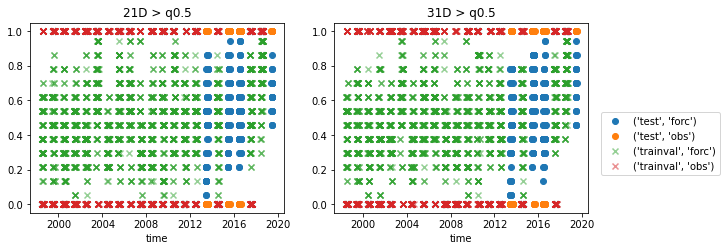

In [216]:
seasonal = False
timescales = [21,31]
preps = [default_prep(f'tg-anom_JJA_45r1_{scale}D-roll-mean_q0.5_sep12-15')[0] for scale in timescales]
props = [compute_props(prep, seasonal = seasonal) for prep in preps]
measures = [compute_measure(prep) for prep in preps]

fig, axes = plt.subplots(ncols = len(timescales), figsize = (10,3.5), squeeze=False)
for scale, key in itertools.product(timescales,props[0].columns):
    index = timescales.index(scale)
    if 'trainval' in key:
        axes[0,index].scatter(x = props[index].index.get_level_values(0), y = props[index][key], label = key, alpha = 0.5, marker = 'x')
    else:
        axes[0,index].scatter(x = props[index].index.get_level_values(0), y = props[index][key], label = key)
    axes[0,index].set_title(f'{scale}D > q0.5')
    axes[0,index].set_xlabel('time')
    
axes[0,-1].legend(loc = (1.05,0.2))
plt.show()

In Seasonal mean mode there is not much to see. Predictands seem very comparable indeed.

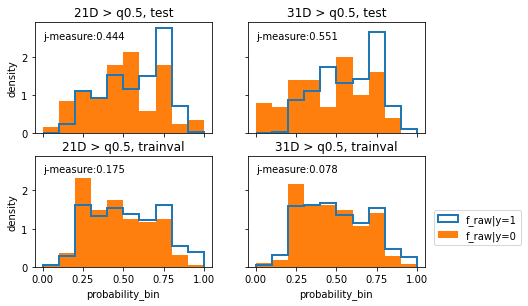

In [220]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, sharex = True, sharey = True, figsize = (7,4.5), facecolor = 'white')

bins = np.arange(0,1.1,0.1)
for what, timescale in itertools.product(['test','trainval'],timescales):
    rowind = ['test','trainval'].index(what)
    colind = timescales.index(timescale)
    frame = props[colind][what]
    ax = axes[rowind,colind]
    ax.hist(frame['forc'].iloc[frame['obs'].astype(bool).values], label = 'f_raw|y=1', bins = bins, histtype = 'step', lw = 2, density = True)
    ax.hist(frame['forc'].iloc[~frame['obs'].astype(bool).values], label = 'f_raw|y=0', bins = bins, density = True)
    ax.set_title(f'{timescale}D > q0.5, {what}')
    ax.text(0.05,0.85,f'j-measure:{np.round(measures[colind][what],3)}',transform=ax.transAxes)

axes[0,0].set_ylabel('density')
axes[1,0].set_ylabel('density')
axes[1,0].set_xlabel('probability_bin')
axes[1,1].set_xlabel('probability_bin')
axes[1,1].legend(loc = (1.05,0.2))
plt.show()

The difference in j-measure value for the test set depends a bit on the min-samples. But overall we can conclude that the quality of the raw model is higher for the 31day forecasts, when looking at the test set.